# Common Voice 23.0 Dataset Preparation for Fine-tuning of Open-source ASR model

This notebook preprocesses the [Common Voice 23.0 Uzbek dataset](https://datacollective.mozillafoundation.org/datasets/cmflnuzw7fd2f0vzknodytok4) for fine-tuning one of the open-source speech recognition model (e.g. Whisper, Wav2Vec, Parakeet-tdt-0.6b). You can find more information about the structure of the dataset [here](https://github.com/common-voice/cv-dataset). The workflow consists of several key stages:
1. Data Loading & Consolidation
2. Data Cleaning & Enrichment
3. Dataset Analysis (dataset plotting and calculate speaker trust scores)
4. Strategic Sampling for Quality Control (by Google SPT)
5. Audio Preprocessing & Quality Validation
6. Audio-Transcription Alignment Quality Check (with Google SPT & Manual Review)

## Data Loading & Consolidation

- Loads train/dev/test splits from TSV files
- Merges additional validated recordings not in official splits
- Combines all data sources into a unified dataset

In [1]:
import os

import pandas as pd
from tqdm import tqdm

SEED = 137
DATASET_DIR = "../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz"
CUSTOM_VALIDATED_CSV_PATH = os.path.join(DATASET_DIR, "custom_validated.csv")
ALL_DATA_CSV_PATH = os.path.join(DATASET_DIR, "all_data.csv")
SAMPLED_RECORDINGS_PATH = os.path.join(DATASET_DIR, "sampled_recordings.csv")
PROCESSED_AUDIO_STATS_PATH = os.path.join(DATASET_DIR, "processed_audio_stats.csv")
TRANSCRIPTION_RESULTS_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions.csv")

COLUMNS_TO_DROP = ["sentence_domain", "accents", "variant", "locale", "segment"]

In [2]:
import csv


def load_data_from_tsv(tsv_path: str) -> pd.DataFrame:
    """Load data from given tsv file with Common Voice specific configurations."""
    return pd.read_csv(
        tsv_path,
        sep="\t",
        quoting=csv.QUOTE_NONE,
        # Important: Common Voice doesn't use quotes at all (yet, pandas default quoting is csv.QUOTE_MINIMAL)
        dtype={"accents": str},
        low_memory=False,
        # Fix the mixed type warning
    )

In [3]:
# Load and combine split data (train.tsv, dev.tsv, test.tsv)
splits = []
for split_name in ["train", "dev", "test"]:
    split_tsv_file = os.path.join(DATASET_DIR, f"{split_name}.tsv")
    df = load_data_from_tsv(split_tsv_file)
    df["type"] = split_name
    splits.append(df)

combined_df = pd.concat(splits, ignore_index=True)

# Load additional validated data that's not already in the custom validated set
validated_df = load_data_from_tsv(os.path.join(DATASET_DIR, "validated.tsv"))
additional_validated_df = validated_df[~validated_df["path"].isin(combined_df["path"])].copy()

# Add additional data to train set
additional_validated_df["type"] = "train"
custom_validated_df = pd.concat([combined_df, additional_validated_df], ignore_index=True)
print(f"Total number of validated entries: {len(custom_validated_df)}")

print(custom_validated_df.info())

# Some speakers have inconsistent age and gender information (sometimes set, sometimes NaN)
custom_validated_df.groupby(["client_id", "gender", "age"], dropna=False).agg({"client_id": "count"})

Total number of validated entries: 87103
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87103 entries, 0 to 87102
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_id        87103 non-null  object 
 1   path             87103 non-null  object 
 2   sentence_id      87103 non-null  object 
 3   sentence         87103 non-null  object 
 4   sentence_domain  0 non-null      float64
 5   up_votes         87103 non-null  int64  
 6   down_votes       87103 non-null  int64  
 7   age              47537 non-null  object 
 8   gender           48096 non-null  object 
 9   accents          743 non-null    object 
 10  variant          0 non-null      float64
 11  locale           87103 non-null  object 
 12  segment          0 non-null      float64
 13  type             87103 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 9.3+ MB
None


client_id
client_id                                          gender         age                
0003767547f3b2fb06d9844f394d8ba7da4fcafbf283a6a... NaN            NaN               1
005b4b58ad4aae5d9a230358c1baaf937a84b17d4d90c71... NaN            NaN              23
007051a4439cd86e313040a2060e49ad724e7bc22228204... NaN            NaN               5
007792d9631b713ae29c51b11f50a6a881f2df62cf6f821... male_masculine twenties         83
                                                   NaN            NaN               5
...                                                                               ...
fdf11d59bf39416f881e32e5d763daec205c14992f64070... NaN            NaN               1
fe62c8d956adf6156df94703f086eefd7a2fc2f5d803f1e... NaN            NaN               2
fea9a299dcdc9bf14918a911102ebc85b6923f437acc461... NaN            NaN               4
fed2f2355b3509d693c77b7dc45cf4951961902f426bf7a... male_masculine twenties          5
ffdd1f0aeb20970880a508c798b98aab8dad09106cfdb45... NaN            NaN              65

[1601 rows x 1 columns]

## Data Cleaning & Enrichment

- Removes unnecessary columns (accents, locale, segments, etc.)
- Adds clip durations and word counts
- Normalizes Uzbek transcription text
- Fills missing speaker demographics (age/gender) by forward/backward filling per speaker

In [4]:
import scripts.uzbek_text_normalizer as utn


def load_clip_durations(dataset_dir: str) -> dict:
    """Load clip durations and return as a dictionary."""
    clip_durations_df = pd.read_csv(os.path.join(dataset_dir, "clip_durations.tsv"), sep="\t")
    clip_durations_df["duration"] = clip_durations_df["duration[ms]"] / 1000
    clip_durations_df.drop(columns=["duration[ms]"], inplace=True)

    return (
        clip_durations_df
        .set_index("clip")["duration"]
        .to_dict()
    )


def fill_known_gender_age_columns(df: pd.DataFrame):
    """
    Fill known gender and age values from each speaker.

    Some speakers have inconsistent age and gender information (sometimes set, sometimes NaN)
    """
    df["gender"] = df["gender"].astype("string")
    df["age"] = df["age"].astype("string")  # For silence warning

    df[["gender", "age"]] = df.groupby("client_id")[["gender", "age"]].transform(
        lambda x: x.ffill().bfill())

    return df


def prepare_final_data(df: pd.DataFrame, dataset_dir: str, output_csv_file_name: str = "output.csv") -> pd.DataFrame:
    """
    Drop unnecessary columns, add clip durations and word count columns,
    normalize transcription text, fill known gender and age values per speaker,
    save the result to csv file.
    """
    # Remove unnecessary columns
    df.drop(
        columns=COLUMNS_TO_DROP,
        inplace=True,
    )

    # Remove rows with sentence is None or whitespace only
    df = df[df["sentence"].notna() & (df["sentence"].str.strip() != '')]

    # Add clip durations
    clip_duration_dict = load_clip_durations(dataset_dir)
    df["duration"] = df["path"].map(clip_duration_dict)

    # Normalize transcription text
    df["sentence"] = df["sentence"].apply(utn.normalize_text)

    # Add word count
    df["word_count"] = df["sentence"].str.split().str.len()

    # Fill missing gender and age per client_id
    df = fill_known_gender_age_columns(df)

    # Save result
    output_csv_path = os.path.join(dataset_dir, output_csv_file_name)
    print(f"Saving to {output_csv_path}...")
    df.to_csv(output_csv_path, index_label="id")

    print(f"✓ Processing complete. Total records: {len(df)}")
    return df


# Final data preparation (drop and add columns, normalize transcription text, save the results to csv)
prepare_final_data(custom_validated_df, DATASET_DIR, output_csv_file_name="custom_validated.csv")

Saving to ../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz/custom_validated.csv...
✓ Processing complete. Total records: 87103


,client_id,path,sentence_id,sentence,up_votes,down_votes,age,gender,type,duration,word_count
0,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907218.mp3,bc07db8b7a00a0b99d7c0ef267d1de330e807c9810eef6...,Bugun ertalab Gyotenikiga taklifnoma oldim.,2,0,twenties,male_masculine,train,4.788,5
1,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907221.mp3,a6530f96b764bd5571b024ea38e448df2deae123e522f0...,Uning badiiy tasvir imkoniyatlarini rivojlanti...,2,0,twenties,male_masculine,train,5.076,5
2,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907226.mp3,c1a227e11d003ffe07a9b86850637ae0e4adfb1351ae72...,Udan ko'ra balandroq joy bor.,2,1,twenties,male_masculine,train,4.140,5
3,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907243.mp3,bb64eb96e0ce5f555cc8d3420687b9b4079165003999ed...,Bu jumlada fig'oni falakka chiqib birikmasi ib...,2,1,twenties,male_masculine,train,7.560,12
4,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907245.mp3,85a5fea3c41d39bcfe0ea6c75b1a1ea7fd9395aeed064b...,Bundan tashqari puxta jamlangan kutubxona bor.,2,1,twenties,male_masculine,train,5.436,6
...,...,...,...,...,...,...,...,...,...,...,...
87098,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30299258.mp3,c6db057a9f4390f5eba23152931ed21106e23267701694...,Ikki,2,0,twenties,female_feminine,train,1.548,1
87099,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30299279.mp3,c70f4b9db0b02db22056d4ef5a1c8cf9eb5c6c82ea0499...,U boshqa kasb etagini tutsin.,2,0,twenties,female_feminine,train,2.736,5
87100,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30299677.mp3,c8f9a9bdaf43fed1bbd5db7c049ecce6601520eb54cc53...,Quyosh ham tolib oyog'i,2,0,twenties,female_feminine,train,2.340,4
87101,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30299721.mp3,c8bc1507705991a9552dc11f3e507f984161a35ffb1bb5...,"Sizga, olavering. Chakkangiz og'riganda kerak ...",2,0,twenties,female_feminine,train,3.960,6


In [5]:
custom_validated_df = pd.read_csv(CUSTOM_VALIDATED_CSV_PATH, index_col="id")

# Compare the results against previous inconsistent age and gender information
print(custom_validated_df.info())
custom_validated_df.groupby(["client_id", "gender", "age"], dropna=False).agg({"client_id": "count"})

<class 'pandas.core.frame.DataFrame'>
Index: 87103 entries, 0 to 87102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    87103 non-null  object 
 1   path         87103 non-null  object 
 2   sentence_id  87103 non-null  object 
 3   sentence     87103 non-null  object 
 4   up_votes     87103 non-null  int64  
 5   down_votes   87103 non-null  int64  
 6   age          79989 non-null  object 
 7   gender       80674 non-null  object 
 8   type         87103 non-null  object 
 9   duration     87103 non-null  float64
 10  word_count   87103 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 8.0+ MB
None


,,,client_id
client_id,gender,age,
0003767547f3b2fb06d9844f394d8ba7da4fcafbf283a6ae4fcc072770701d81380c5a5666eadf5b87dd678972e27939b6dbb73a4fa515fae440d2a45d0ae940,NaN,NaN,1
005b4b58ad4aae5d9a230358c1baaf937a84b17d4d90c71e1128c1373febfe1f2114b652b8d4221a6c565c015a23cd1761dfdcf4196b05e01632ca43e281b3f0,NaN,NaN,23
007051a4439cd86e313040a2060e49ad724e7bc22228204d2bca3ae178a1bbffc45478b5a9e7d073cfd8af761112fb4270029f8013c0c27c467629d63f64381d,NaN,NaN,5
007792d9631b713ae29c51b11f50a6a881f2df62cf6f821b10aeb46b523a5f443554ab36121a843938d1b748a87068550e40c263143ffa31bb3a6e337a803150,male_masculine,twenties,88
008a642a3f1b0f750c3bec478088f666ab9929557c3d0e834c564adeb7d65b3256b78c7a1e4d09822373bbb47435c5abf7f244b881c4411b28d5af928db3deb3,NaN,NaN,1
...,...,...,...
fdf11d59bf39416f881e32e5d763daec205c14992f640702da21b0138e74c09bf9d08a9254ade92dd51e1b39048093f81f35ae31a02cdb8b9ec4c9308dd4caea,NaN,NaN,1
fe62c8d956adf6156df94703f086eefd7a2fc2f5d803f1e8096d357569bf72a6daf2813d00151f73f8cea8b3fa0c9d95f9aecfd9e4f46e7cfdcc9258aefdc499,NaN,NaN,2
fea9a299dcdc9bf14918a911102ebc85b6923f437acc461150be644cbdfde1efde2e130bada237c0f216aa693ad72c2cf9308408102c7f9a31d470315be352b0,NaN,NaN,4


In [6]:
print(custom_validated_df.info())
print(custom_validated_df.describe())
print("\nFirst few rows:")
custom_validated_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 87103 entries, 0 to 87102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    87103 non-null  object 
 1   path         87103 non-null  object 
 2   sentence_id  87103 non-null  object 
 3   sentence     87103 non-null  object 
 4   up_votes     87103 non-null  int64  
 5   down_votes   87103 non-null  int64  
 6   age          79989 non-null  object 
 7   gender       80674 non-null  object 
 8   type         87103 non-null  object 
 9   duration     87103 non-null  float64
 10  word_count   87103 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 8.0+ MB
None
           up_votes    down_votes      duration    word_count
count  87103.000000  87103.000000  87103.000000  87103.000000
mean       2.015602      0.185034      4.396574      6.269049
std        0.153555      0.390950      1.539892      2.643489
min        2.000000      0.000000  

,client_id,path,sentence_id,sentence,up_votes,down_votes,age,gender,type,duration,word_count
id,,,,,,,,,,,
0,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907218.mp3,bc07db8b7a00a0b99d7c0ef267d1de330e807c9810eef6...,Bugun ertalab Gyotenikiga taklifnoma oldim.,2,0,twenties,male_masculine,train,4.788,5
1,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907221.mp3,a6530f96b764bd5571b024ea38e448df2deae123e522f0...,Uning badiiy tasvir imkoniyatlarini rivojlanti...,2,0,twenties,male_masculine,train,5.076,5
2,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907226.mp3,c1a227e11d003ffe07a9b86850637ae0e4adfb1351ae72...,Udan ko'ra balandroq joy bor.,2,1,twenties,male_masculine,train,4.140,5
3,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907243.mp3,bb64eb96e0ce5f555cc8d3420687b9b4079165003999ed...,Bu jumlada fig'oni falakka chiqib birikmasi ib...,2,1,twenties,male_masculine,train,7.560,12
4,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907245.mp3,85a5fea3c41d39bcfe0ea6c75b1a1ea7fd9395aeed064b...,Bundan tashqari puxta jamlangan kutubxona bor.,2,1,twenties,male_masculine,train,5.436,6


In [7]:
other_df = load_data_from_tsv(os.path.join(DATASET_DIR, "other.tsv"))
other_df["type"] = "other"
other_df = prepare_final_data(other_df, DATASET_DIR, "other.csv")

invalidated_df = load_data_from_tsv(os.path.join(DATASET_DIR, "invalidated.tsv"))
invalidated_df["type"] = "invalidated"
invalidated_df = prepare_final_data(invalidated_df, DATASET_DIR, "invalidated.csv")

all_data_df = pd.concat([custom_validated_df, other_df, invalidated_df], ignore_index=True)
print(f"Saving to {ALL_DATA_CSV_PATH}...")
all_data_df.to_csv(ALL_DATA_CSV_PATH, index_label="id")
print(f"✓ Processing complete. Total records: {len(all_data_df)}")
all_data_df.info()

Saving to ../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz/other.csv...
✓ Processing complete. Total records: 128485


/tmp/ipykernel_19906/3248158290.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["duration"] = df["path"].map(clip_duration_dict)
/tmp/ipykernel_19906/3248158290.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentence"] = df["sentence"].apply(utn.normalize_text)
/tmp/ipykernel_19906/3248158290.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Saving to ../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz/invalidated.csv...
✓ Processing complete. Total records: 14116
Saving to ../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz/all_data.csv...
✓ Processing complete. Total records: 229704
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229704 entries, 0 to 229703
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   client_id    229704 non-null  object 
 1   path         229704 non-null  object 
 2   sentence_id  229704 non-null  object 
 3   sentence     229704 non-null  object 
 4   up_votes     229704 non-null  int64  
 5   down_votes   229704 non-null  int64  
 6   age          193238 non-null  object 
 7   gender       194395 non-null  object 
 8   type         229704 non-null  object 
 9   duration     229704 non-null  float64
 10  word_count   229704 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 19.3+ 

## Dataset Analysis

- Generates distribution plots (duration, gender, demographics)
- Calculates speaker trust scores based on up/down votes
- Analyzes speaker recording patterns and quality metrics

### Dataset Plotting

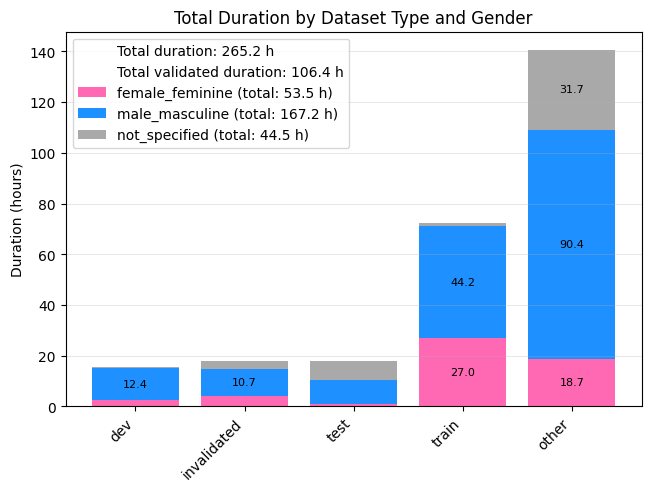

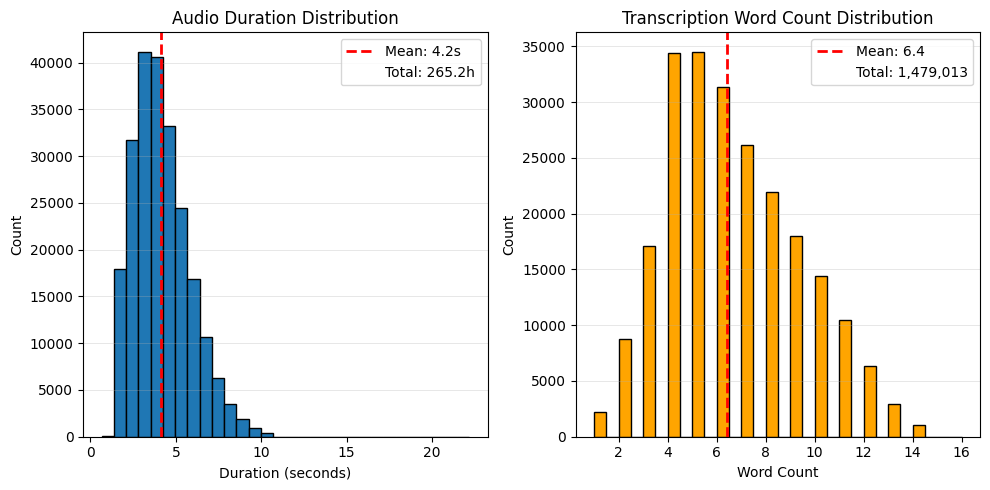

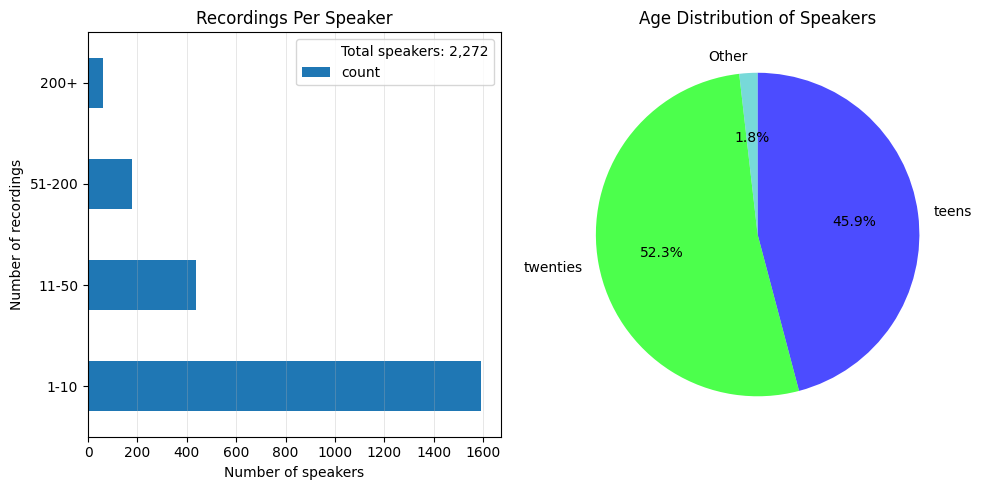

The custom validated dataset includes 87,103 samples. Among them, 80.9% have a positive difference of 2, while 18.2% have a difference of 1.


true_votes
2    70424
1    15863
3      558
4      238
6       11
5        9
Name: count, dtype: int64

In [8]:
from scripts.dataset_plotting import plot_distribution_graphs, plot_dataset_type_gender_distribution, \
    plot_demographic_statistics, plot_speaker_trust_score_distribution

plot_dataset_type_gender_distribution(all_data_df)
plot_distribution_graphs(all_data_df)
plot_demographic_statistics(all_data_df)

# Compute true votes (up_votes - down_votes) and its distribution
custom_validated_df = pd.read_csv(CUSTOM_VALIDATED_CSV_PATH, index_col="id")
custom_validated_df["true_votes"] = (
        custom_validated_df["up_votes"] - custom_validated_df["down_votes"]
)

# Free up memory
del all_data_df, other_df, invalidated_df

total_custom_validated_entries = len(custom_validated_df)
true_votes_count = custom_validated_df["true_votes"].value_counts()
print(
    f"The custom validated dataset includes {total_custom_validated_entries:,} samples. Among them, {100 * true_votes_count.iloc[0] / total_custom_validated_entries:.1f}% have a positive difference of {true_votes_count.keys()[0]}, while {100 * true_votes_count.iloc[1] / total_custom_validated_entries:.1f}% have a difference of {true_votes_count.keys()[1]}.")
true_votes_count

### Calculate Speaker Trust Scores

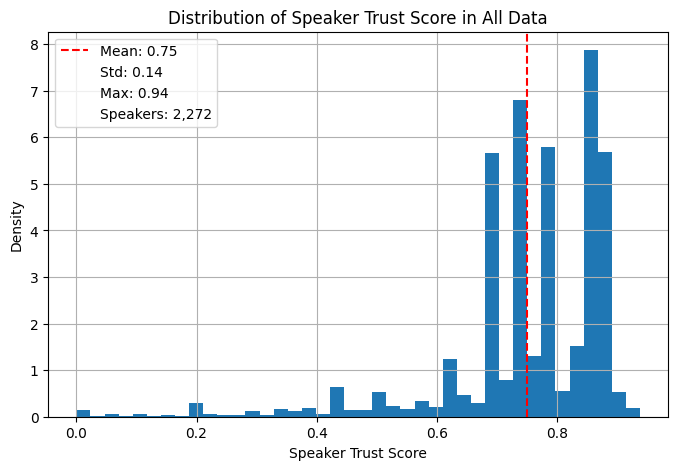

,,up_votes,down_votes,num_recordings
client_id,speaker_trust_score,,,
63c30d8f047df7491379e2bcb6ae54864b35cf1cbd55fd9b0d12a460ea26eb690a699dc540b14b171449ca8d71da92a95ffd22eeef92e04aa18a08c196cd7e43,0.9379,434,18,224
f763d1835e4436a3a85f271bf404cdbcf23f9b9c6f7d4d76772ab58246f52f10b6ea6697e454caa590e7fc49f2d47db547a0d584303e1f113346ab93378d5ef4,0.9375,806,39,404
b5e51f0ffdf226e4c74bc2037bbd9d5a79dbf9660e880f6eb6216f1f9937d172dfda25db5ba2006f18033b83be81e8abf39e0909186eeb7acf41c510dda91d5e,0.9367,109,2,58
44c15c0f726ba78cb2a2f545eebe60e36e997c805e44d1e3672a2e0152f91a9b10a38873c074b7e7efec7d28802e98d0a8ec81e2ba47e9aa8c869a2e68f8fb97,0.9236,126,4,63
b4968971e35c5a65c94480ab31561c7b12ae289bb23e1dade0997e13137c92812e130113f257dc7cf9562bfa11b30a704dfed02cf3fe7d58848214c2cbf5fe34,0.9224,68,1,35
...,...,...,...,...
f679bce4fb519e51f14104a265400e0eea6eafe454420aa7514cf143eded37955ffa2938e608876b200322eef79a3497251670198112e643b0c2eeb3cc2cbecb,0.0000,0,10,5
79295ce47f1be5826e279f29f0779a366a035e8bf77ea3dfdb116a347b8bae95919fb7eac84ea263eab270e9ab00fcffce82a432f3961f1e33330c60bea51857,0.0000,0,1,3
930551688e12393b5a04054f2a877a69c5d347fffed64b1a666f867a22b79595382dc164069e79c516fddd5ed0f0ace394c361ede18b953dec26c23d16cd63f0,0.0000,0,1,10


In [9]:
import scripts.speaker_trust_score

all_data_df = pd.read_csv(ALL_DATA_CSV_PATH, index_col="id")
all_data_df = scripts.speaker_trust_score.trust_score(all_data_df)
all_data_df.to_csv(ALL_DATA_CSV_PATH)

plot_speaker_trust_score_distribution(all_data_df, data_frame_title="All Data")

grouped = (
    all_data_df
    .groupby(["client_id", "speaker_trust_score"])
    .agg({
        "up_votes": "sum",
        "down_votes": "sum",
        "client_id": "count",  # counts recordings per speaker
    })
    .rename(columns={"client_id": "num_recordings"})
)
grouped.sort_values(
    by="speaker_trust_score",
    ascending=False
)

## Strategic Sampling for Quality Control (by Google SPT)

- Extracts ~3,600 recordings (8.2 hours audios) from non-validated ("other") set to be checked the alignment of audio-transcription by Google's Speech-to-Text model
- Targets medium-trust speakers (0.30-0.75 score) with longer recordings (3-15s)
- Samples stratified by duration: 300 short (3-6s), 800 medium (6-8s), all long (8-15s)
- Total: ~2-3 hours of audio for manual validation

In [10]:
other_df = all_data_df[all_data_df["type"] == "other"].reset_index(drop=True)
other_df.index.name = "id"

other_df_grouped = (
    other_df
    .groupby(["client_id", "speaker_trust_score"])
    .agg({
        "up_votes": "sum",
        "down_votes": "sum",
        "client_id": "count",  # counts recordings per speaker
    })
    .rename(columns={"client_id": "num_recordings"})
).reset_index()

speakers_to_check = other_df_grouped[
    (other_df_grouped["speaker_trust_score"] < 0.75) &
    (other_df_grouped["speaker_trust_score"] > 0.30)
    ]

speakers_to_check = speakers_to_check.sort_values(
    by="num_recordings", ascending=False
).head(300)
speakers_to_check

,client_id,speaker_trust_score,up_votes,down_votes,num_recordings
922,b7808eea20000dd73de504f3d1b545ee8e39025baca405...,0.6816,5097,3731,21593
945,bc69c744bf0f8464394b0554f6d87cc8e1bb9286bf3d13...,0.7333,4494,4189,18740
895,b303b536e41d001670724c7f7902bae04eb218dcb714e1...,0.6494,205,90,980
939,ba6259effb0707163a6a7c2440301ffc466461192eea3a...,0.6181,145,65,581
1002,c83c69afe7f26b08b118c14ca76dfe812177d8acca62ea...,0.7352,92,23,456
...,...,...,...,...,...
121,1ab81b39ba79e347dc49dc60fecc2401504c190abe9ab4...,0.3755,2,1,9
1037,d0c3874f59c5fd3de9294e8093f984a7eac9eb1ea0261c...,0.6097,4,0,9
530,6def659c15a16f52b60189ed75ced6474cc37e98aebabb...,0.7256,0,0,9
352,4b8db9ad0bc8578ff93dc23cb847913a59ee13ee05e4e3...,0.5000,0,0,9


In [11]:
# Filter only these top speakers
speaker_ids = speakers_to_check["client_id"].tolist()
top_speakers_to_check = other_df["client_id"].isin(speaker_ids)

# Filter longer duration recordings
short_audios = (other_df["duration"] >= 3) & (other_df["duration"] < 6)
medium_audios = (other_df["duration"] >= 6) & (other_df["duration"] < 8)
long_audios = (other_df["duration"] >= 8) & (other_df["duration"] <= 15)

short_recordings = (
    other_df[short_audios & top_speakers_to_check]
    .groupby("client_id")
    .apply(lambda x: x.sample(min(len(x), 30)), include_groups=False)  # Maximum up to 30 recordings per speaker
    .reset_index(level=0)
).sample(300, weights="duration", random_state=SEED)
print(f"short_recordings: \n{short_recordings["client_id"].describe()}")

medium_recordings = (
    other_df[medium_audios & top_speakers_to_check]
    .groupby("client_id")
    .apply(lambda x: x.sample(min(len(x), 50)), include_groups=False)  # Maximum up to 50 recordings per speaker
    .reset_index(level=0)
).sample(800, weights="duration", random_state=SEED)
print(f"\nmedium_recordings: \n{medium_recordings["client_id"].describe()}")

long_recordings = other_df[long_audios]
print(f"\nlong_recordings: \n{long_recordings["client_id"].describe()}")

sampled_recordings_df = pd.concat([short_recordings, medium_recordings, long_recordings]).sort_index()
print(f"\nsampled_recordings: \n{sampled_recordings_df["client_id"].describe()}")

total_sampled_duration = sampled_recordings_df["duration"].sum(axis=0) / 3600
print(f"\nTotal sampled duration: {total_sampled_duration:,.2f}h")

sampled_recordings_df["type"] = "other"
sampled_recordings_df.to_csv(SAMPLED_RECORDINGS_PATH)
sampled_recordings_df

short_recordings: 
count                                                   300
unique                                                  184
top       e0178b2ed6d002603bbe4efaec2daa398ebbf7a48e4bac...
freq                                                      6
Name: client_id, dtype: object

medium_recordings: 
count                                                   800
unique                                                  234
top       b7808eea20000dd73de504f3d1b545ee8e39025baca405...
freq                                                     18
Name: client_id, dtype: object

long_recordings: 
count                                                  2562
unique                                                  630
top       30fd02023d452dbd8d83510cf487aabca11a7138c6245b...
freq                                                    225
Name: client_id, dtype: object

sampled_recordings: 
count                                                  3662
unique                                        

,client_id,path,sentence_id,sentence,up_votes,down_votes,age,gender,type,duration,word_count,speaker_trust_score
id,,,,,,,,,,,,
22,f472b9041ed520010f3057ec877359962118d70ab883b9...,common_voice_uz_29007503.mp3,66306770bc5bce055e622869d1c43fc98f6562a0dff39a...,Jonli va jonsiz narsalarni bildiruvchi boshqa ...,0,1,teens,male_masculine,other,9.360,10,0.0982
67,60d8d81ca356533bbfcd36f93ff734211cb2aa6b540cc5...,common_voice_uz_29055349.mp3,046d199aefc23554546a8ad4a5c6bd9fd309fac8d7da43...,Vaqt yoki dam olish vaqti adras ko'ylakni kiyi...,1,0,twenties,male_masculine,other,8.316,14,0.7509
71,60d8d81ca356533bbfcd36f93ff734211cb2aa6b540cc5...,common_voice_uz_29055365.mp3,06ec2fe357d58e6094c28646dda9d475d50ff7f17852fe...,"Mansab pillapoyalaridan ko'tarilganda, xalqqa ...",1,0,twenties,male_masculine,other,10.116,10,0.7509
99,28f17a51e3d73a411606697113f170b2cf1e419c2c1768...,common_voice_uz_29055717.mp3,04bb488d1372d7819f8e2590c61de4d8144e7c2446fc33...,Bundan keyin nazoratini qila olmaysiz.,1,0,twenties,female_feminine,other,4.320,5,0.7219
115,60d8d81ca356533bbfcd36f93ff734211cb2aa6b540cc5...,common_voice_uz_29055855.mp3,01c755675baa7543cf02624ecfa6c5453c549ae1f4d314...,Hukumatning tepasidagi juda katta amaldorlarni...,1,0,twenties,male_masculine,other,9.720,14,0.7509
...,...,...,...,...,...,...,...,...,...,...,...,...
128465,2143e2fad4e7de42747b75f150a204a5c1192339ade7c2...,common_voice_uz_43495076.mp3,98e546f3059152120502451f9969dabb9e44cfe4190563...,Ronaldu ketgach uzoq vaqt bosim ostida o'ynadi...,0,0,NaN,NaN,other,5.616,8,0.5000
128467,99624694dd5079c29c4b955a58b0aeb8fe1ca6ade80916...,common_voice_uz_43506369.mp3,0013dd32881284bb0bedc22b601083eb3be468c3891da6...,Unda haqiqatni gapirishga izn bering,0,0,NaN,NaN,other,10.008,5,0.5000
128470,6f44c71af2e2d25da8099d59c8aa9de0331c654a57d40f...,common_voice_uz_43526807.mp3,97a970e52488c2421a375821ed9c82ecb1d4c948d30b02...,"Buni qarangki, Yoshlar ittifoqi shahar kengash...",0,0,twenties,male_masculine,other,9.396,14,0.6737


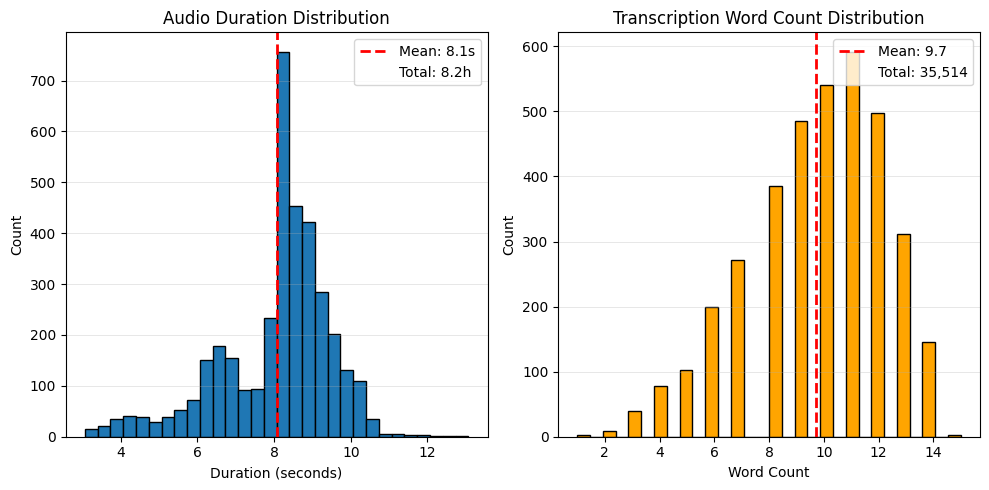

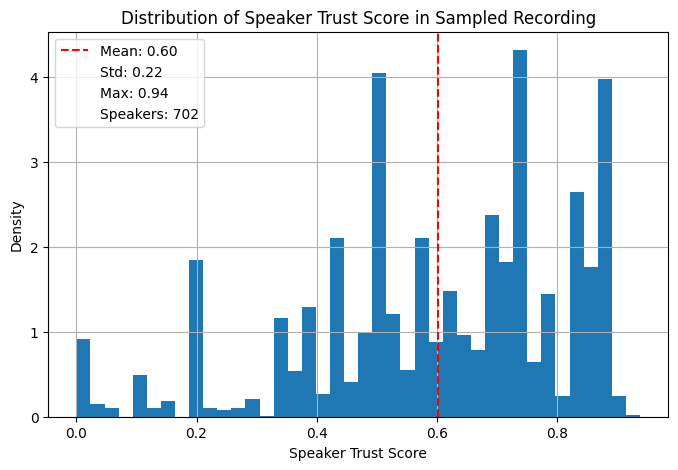

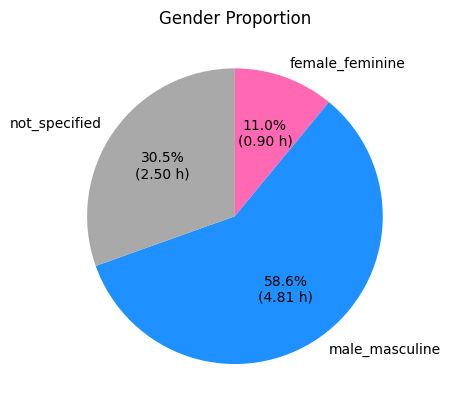

In [12]:
from scripts.dataset_plotting import plot_gender_pie_chart

plot_distribution_graphs(sampled_recordings_df)
plot_speaker_trust_score_distribution(sampled_recordings_df, data_frame_title="Sampled Recording")
plot_gender_pie_chart(sampled_recordings_df)

del other_df

## Audio Preprocessing & Quality Validation

- Performs two types of audio processing with all sampled recordings: 1) preserves original audio (only resamples to 16 kHz, converts to mono and WAV format); 2) applies same steps as above and followings as well:
    - Applies high-pass filter (80 Hz cutoff) to remove low-frequency noise
    - Removes leading/trailing silence (threshold: -45 dB, min: 1.3s)
    - Applies audio volume normalization (target RMS: -23 dB)
    - If required, applies soft limiting to prevent clipping (threshold: 0.95)
    - Creates audio specific statistics before and after audio processing to be reviewed
- Reviews audio preprocessing results with side-by-side comparisons
- Flags and removes recordings that became too short (<2s after silence removal)
- Down-votes suspicious recordings where excessive silence was detected

In [13]:
import scripts.audio_preporocessing as ap
import glob

sampled_recordings_df = pd.read_csv(SAMPLED_RECORDINGS_PATH, index_col="id")

sampled_original_recordings_directory = os.path.join(DATASET_DIR, "sampled_clips_original")
if not os.path.exists(sampled_original_recordings_directory):
    os.makedirs(sampled_original_recordings_directory)

# Extract sampled audios and standardize to 16 kHz
new_audio_extension = "wav"
for audio_path in tqdm(sampled_recordings_df["path"], desc="Processing files"):
    file_name, file_extension = os.path.splitext(audio_path)
    full_audio_path = os.path.join(DATASET_DIR, "clips", audio_path)
    path_to_save = os.path.join(sampled_original_recordings_directory, f"{file_name}.{new_audio_extension}")

    ap.resample_audio(full_audio_path, target_sr=16_000, save_path=path_to_save)

saved_recordings = glob.glob(f"{sampled_original_recordings_directory}/*.{new_audio_extension}")
assert len(sampled_recordings_df["path"].unique()) == len(saved_recordings)
print(f"Extracted {len(saved_recordings)} audios and resampled to 16 kHZ")

Processing files: 100%|██████████| 3662/3662 [00:21<00:00, 169.12it/s]

Extracted 3662 audios and resampled to 16 kHZ


In [14]:
from pathlib import Path
from scripts.audio_preporocessing import process_audio_file

stats = []
sampled_normalized_recording_directory = os.path.join(DATASET_DIR, "sampled_clips_normalized")
for audio_file_path in tqdm(saved_recordings, desc="Processing files"):
    audio_filename = Path(audio_file_path).name
    waveform, stat = process_audio_file(
        audio_file_path,
        save_path=os.path.join(sampled_normalized_recording_directory, audio_filename),
        normalize=True,
        target_rms_db=-23.0,
        apply_highpass=True,
        highpass_cutoff=80.0,
        remove_silences=True,
        silence_threshold_db=-45.0,
        min_silence_duration=1.3,
    )
    stats.append(stat)

processed_audio_stats_df = pd.DataFrame(stats)
processed_audio_stats_df

Processing files: 100%|██████████| 3662/3662 [01:02<00:00, 59.00it/s]


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,common_voice_uz_30252783.wav,-15.5385,-23.0988,8.208,8.208,0.000,0.3409,False
1,common_voice_uz_32132849.wav,-27.6651,-23.1238,7.776,3.810,3.966,0.4451,False
2,common_voice_uz_29671041.wav,-25.1509,-23.2657,9.756,9.756,0.000,0.6340,False
3,common_voice_uz_29200656.wav,-31.0495,-23.1830,9.180,4.600,4.580,0.5550,False
4,common_voice_uz_32263657.wav,-24.8811,-23.1562,10.440,9.440,1.000,0.5411,False
...,...,...,...,...,...,...,...,...
3657,common_voice_uz_30488755.wav,-31.8213,-23.2051,5.940,5.940,0.000,0.5403,False
3658,common_voice_uz_32380688.wav,-29.5770,-23.3818,8.280,7.220,1.060,0.7551,False
3659,common_voice_uz_30181075.wav,-16.6817,-23.1494,8.100,8.100,0.000,0.3952,False
3660,common_voice_uz_31930408.wav,-61.8767,-23.1018,8.460,0.500,7.960,0.5874,False


### Audio Pre-processing Manual Quality Validation

In [15]:
from IPython.display import HTML, display


def two_audio_columns(stats_dict, original_audios_directory, normalized_audios_directory):
    html = "<table>"
    for audio_filename, stat in stats_dict.items():
        html += "<tr>"
        html += f"<td style='padding:10px; vertical-align:top;'>"
        html += f"<audio controls><source src='{os.path.join(original_audios_directory, audio_filename)}' type='audio/wav'></audio>"
        html += f"<p>Original rms: {stat['original_rms_db']} dB | original duration: {stat['original_duration']}</p>"
        html += "</td>"

        html += f"<td style='padding:10px; vertical-align:top;'>"
        html += f"<audio controls><source src='{os.path.join(normalized_audios_directory, audio_filename)}' type='audio/wav'></audio>"
        html += f"<p>Normalized rms: {stat['final_rms_db']} dB | reduced duration: {stat['reduced_duration']} | <b>{audio_filename}</b></p>"
        html += "</td>"
        html += "</tr>"
    html += "</table>"
    display(HTML(html))


top_low_original_rms_dict = processed_audio_stats_df.sort_values("original_rms_db", ascending=True).head(30).set_index(
    "input_audio_filename").to_dict("index")
two_audio_columns(top_low_original_rms_dict, sampled_original_recordings_directory,
                  sampled_normalized_recording_directory)

Original rms: -inf dB | original duration: 7.2,Normalized rms: -inf dB | reduced duration: 6.7 | common_voice_uz_33945776.wav
Original rms: -87.9059 dB | original duration: 8.1,Normalized rms: -23.1255 dB | reduced duration: 7.6 | common_voice_uz_31869097.wav
Original rms: -84.0538 dB | original duration: 10.116,Normalized rms: -23.0563 dB | reduced duration: 9.616 | common_voice_uz_34599790.wav
Original rms: -75.733 dB | original duration: 10.476,Normalized rms: -23.1396 dB | reduced duration: 9.976 | common_voice_uz_30385484.wav
Original rms: -74.7547 dB | original duration: 8.676,Normalized rms: -inf dB | reduced duration: 8.176 | common_voice_uz_32280804.wav
Original rms: -74.0682 dB | original duration: 8.748,Normalized rms: -23.0643 dB | reduced duration: 8.248 | common_voice_uz_30385487.wav
Original rms: -72.7983 dB | original duration: 6.516,Normalized rms: -23.0651 dB | reduced duration: 6.016 | common_voice_uz_35207980.wav
Original rms: -71.891 dB | original duration: 9.468,Normalized rms: -23.2093 dB | reduced duration: 8.968 | common_voice_uz_31714504.wav
Original rms: -69.9662 dB | original duration: 9.216,Normalized rms: -27.5906 dB | reduced duration: 8.196 | common_voice_uz_30257371.wav
Original rms: -63.4223 dB | original duration: 8.568,Normalized rms: -inf dB | reduced duration: 8.068 | common_voice_uz_34550799.wav
Original rms: -61.8767 dB | original duration: 8.46,Normalized rms: -23.1018 dB | reduced duration: 7.96 | common_voice_uz_31930408.wav


In [16]:
# --- Replace sampled_recordings_df.duration using processed_audio_stats_df.final_duration ---

# Fix original extension (.wav → .mp3) in processed stats
processed_audio_stats_df["path_mp3"] = (
    processed_audio_stats_df["input_audio_filename"]
    .str.replace(".wav", ".mp3", regex=False)
)

# Merge final_duration into the sampled dataframe
sampled_recordings_df = sampled_recordings_df.merge(
    processed_audio_stats_df[["path_mp3", "final_duration"]],
    how="left",
    left_on="path",
    right_on="path_mp3"
)

# Replace duration only where we have final_duration
sampled_recordings_df["duration"] = (
    sampled_recordings_df["final_duration"].combine_first(sampled_recordings_df["duration"])
)

# Drop helper columns
sampled_recordings_df = sampled_recordings_df.drop(columns=["path_mp3", "final_duration"])

# --- Remove suspiciously short and short recordings (also down-vote the former)  ---

# Suspiciously short => down vote and remove these records
mask_down_vote = (
        (processed_audio_stats_df["final_duration"] < 2) &
        (processed_audio_stats_df["reduced_duration"] > 2)
)
# Short audios => only remove (no down voting)
mask_short_audio = (processed_audio_stats_df["final_duration"] < 3)

paths_to_down_vote = processed_audio_stats_df.loc[mask_down_vote, "input_audio_filename"].tolist()
paths_with_short_audio = processed_audio_stats_df.loc[mask_short_audio, "input_audio_filename"].tolist()

total_reduced_duration = processed_audio_stats_df["reduced_duration"].sum() / 3600

# Remove these rows from processed stats
processed_audio_stats_df = processed_audio_stats_df[
    ~processed_audio_stats_df["input_audio_filename"].isin(paths_with_short_audio)
]

# Convert filenames for sampled_recordings_df (.wav → .mp3)
paths_to_down_vote_mp3 = [p.replace(".wav", ".mp3") for p in paths_to_down_vote]
paths_to_remove_mp3 = [p.replace(".wav", ".mp3") for p in paths_with_short_audio]

old_total_duration = sampled_recordings_df["duration"].sum() / 3600
old_duration_mean = sampled_recordings_df["duration"].mean()

# Increase down-votes
sampled_recordings_df.loc[
    sampled_recordings_df["path"].isin(paths_to_down_vote_mp3),
    "down_votes"
] += 1
print(f"{len(paths_to_down_vote_mp3)} recordings are down-voted")

# Remove these recordings entirely
sampled_recordings_df = sampled_recordings_df[
    ~sampled_recordings_df["path"].isin(paths_to_remove_mp3)
]
print(f"{len(paths_to_remove_mp3)} recordings are removed from the sample")

# Updated totals
current_total_duration = processed_audio_stats_df["final_duration"].sum() / 3600
current_duration_mean = processed_audio_stats_df["final_duration"].mean()

# Save updated CSVs
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH)
sampled_recordings_df.to_csv(SAMPLED_RECORDINGS_PATH, index_label="id")

print(
    f"Before audio preprocessing: total duration - {old_total_duration:,.3f} h | mean {old_duration_mean:,.1f} s"
)
print(
    f"After audio preprocessing: total duration - {current_total_duration:,.3f} h "
    f"(reduced {total_reduced_duration * 60:.0f} min) | mean {current_duration_mean:,.1f} s"
)

sampled_recordings_df

21 recordings are down-voted
34 recordings are removed from the sample
Before preprocessing: total duration - 7.669 h | mean 7.5 s
After preprocessing: total duration - 7.655 h (reduced 32 min) | mean 7.6 s


,client_id,path,sentence_id,sentence,up_votes,down_votes,age,gender,type,duration,word_count,speaker_trust_score
0,f472b9041ed520010f3057ec877359962118d70ab883b9...,common_voice_uz_29007503.mp3,66306770bc5bce055e622869d1c43fc98f6562a0dff39a...,Jonli va jonsiz narsalarni bildiruvchi boshqa ...,0,1,teens,male_masculine,other,9.360,10,0.0982
1,60d8d81ca356533bbfcd36f93ff734211cb2aa6b540cc5...,common_voice_uz_29055349.mp3,046d199aefc23554546a8ad4a5c6bd9fd309fac8d7da43...,Vaqt yoki dam olish vaqti adras ko'ylakni kiyi...,1,0,twenties,male_masculine,other,8.316,14,0.7509
2,60d8d81ca356533bbfcd36f93ff734211cb2aa6b540cc5...,common_voice_uz_29055365.mp3,06ec2fe357d58e6094c28646dda9d475d50ff7f17852fe...,"Mansab pillapoyalaridan ko'tarilganda, xalqqa ...",1,0,twenties,male_masculine,other,10.116,10,0.7509
3,28f17a51e3d73a411606697113f170b2cf1e419c2c1768...,common_voice_uz_29055717.mp3,04bb488d1372d7819f8e2590c61de4d8144e7c2446fc33...,Bundan keyin nazoratini qila olmaysiz.,1,0,twenties,female_feminine,other,4.320,5,0.7219
4,60d8d81ca356533bbfcd36f93ff734211cb2aa6b540cc5...,common_voice_uz_29055855.mp3,01c755675baa7543cf02624ecfa6c5453c549ae1f4d314...,Hukumatning tepasidagi juda katta amaldorlarni...,1,0,twenties,male_masculine,other,9.720,14,0.7509
...,...,...,...,...,...,...,...,...,...,...,...,...
3657,2143e2fad4e7de42747b75f150a204a5c1192339ade7c2...,common_voice_uz_43495076.mp3,98e546f3059152120502451f9969dabb9e44cfe4190563...,Ronaldu ketgach uzoq vaqt bosim ostida o'ynadi...,0,0,NaN,NaN,other,4.770,8,0.5000
3658,99624694dd5079c29c4b955a58b0aeb8fe1ca6ade80916...,common_voice_uz_43506369.mp3,0013dd32881284bb0bedc22b601083eb3be468c3891da6...,Unda haqiqatni gapirishga izn bering,0,0,NaN,NaN,other,10.008,5,0.5000
3659,6f44c71af2e2d25da8099d59c8aa9de0331c654a57d40f...,common_voice_uz_43526807.mp3,97a970e52488c2421a375821ed9c82ecb1d4c948d30b02...,"Buni qarangki, Yoshlar ittifoqi shahar kengash...",0,0,twenties,male_masculine,other,8.286,14,0.6737
3660,6f44c71af2e2d25da8099d59c8aa9de0331c654a57d40f...,common_voice_uz_43526809.mp3,97a83ac2c136f2442b35064fbf1a7c12622489ca04f4f7...,Chunki auditoriya film suratga olinayotgan pay...,0,0,twenties,male_masculine,other,7.820,12,0.6737


In [17]:
print(processed_audio_stats_df.describe())
processed_audio_stats_df

       original_rms_db  final_rms_db  original_duration  final_duration  \
count      3628.000000   3628.000000        3628.000000     3628.000000   
mean        -23.857933    -23.212125           8.072514        7.595673   
std           5.373794      0.117382           1.434627        1.542957   
min         -53.785600    -26.013300           3.060000        3.000000   
25%         -26.458200    -23.246925           7.407000        6.609000   
50%         -23.455800    -23.184750           8.316000        8.057000   
75%         -20.080975    -23.145500           8.928000        8.640000   
max         -11.274200    -23.060100          13.068000       12.744000   

       reduced_duration  peak_amplitude  
count       3628.000000     3628.000000  
mean           0.476841        0.556592  
std            0.961078        0.118756  
min            0.000000        0.254300  
25%            0.000000        0.469675  
50%            0.000000        0.545100  
75%            0.860000       

,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped,path_mp3
0,common_voice_uz_30252783.wav,-15.5385,-23.0988,8.208,8.208,0.000,0.3409,False,common_voice_uz_30252783.mp3
1,common_voice_uz_32132849.wav,-27.6651,-23.1238,7.776,3.810,3.966,0.4451,False,common_voice_uz_32132849.mp3
2,common_voice_uz_29671041.wav,-25.1509,-23.2657,9.756,9.756,0.000,0.6340,False,common_voice_uz_29671041.mp3
3,common_voice_uz_29200656.wav,-31.0495,-23.1830,9.180,4.600,4.580,0.5550,False,common_voice_uz_29200656.mp3
4,common_voice_uz_32263657.wav,-24.8811,-23.1562,10.440,9.440,1.000,0.5411,False,common_voice_uz_32263657.mp3
...,...,...,...,...,...,...,...,...,...
3656,common_voice_uz_33794448.wav,-18.0525,-23.1489,8.460,8.460,0.000,0.4358,False,common_voice_uz_33794448.mp3
3657,common_voice_uz_30488755.wav,-31.8213,-23.2051,5.940,5.940,0.000,0.5403,False,common_voice_uz_30488755.mp3
3658,common_voice_uz_32380688.wav,-29.5770,-23.3818,8.280,7.220,1.060,0.7551,False,common_voice_uz_32380688.mp3
3659,common_voice_uz_30181075.wav,-16.6817,-23.1494,8.100,8.100,0.000,0.3952,False,common_voice_uz_30181075.mp3


## Audio-Transcription Alignment Quality Check (with Google SPT & Manual Review)

-

In [18]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
import time

from scripts import google_transcribe
from google.api_core.exceptions import MethodNotImplemented, ResourceExhausted, ServiceUnavailable

sampled_recordings_df = pd.read_csv(SAMPLED_RECORDINGS_PATH, index_col="id").sample(15, random_state=SEED)

sampled_normalized_recordings_directory = os.path.join(DATASET_DIR, "sampled_clips_normalized")

predicted_transcriptions = []
failed_count = 0
success_count = 0

for audio_filename in tqdm(sampled_recordings_df["path"], desc="Google SPT processing"):
    normalized_audio_filename = audio_filename.replace(".mp3", ".wav")
    audio_path = os.path.join(sampled_normalized_recordings_directory, normalized_audio_filename)

    result = {
        "path": audio_filename,
        "predicted_sentence": None,
        "error_message": None,
        "error_type": None,
    }

    response = None
    try:
        response = google_transcribe.transcribe_with_retry(audio_path)
    except google_transcribe.GoogleCloudProjectIdNotSet as err:
        print(f"\nConfiguration error: {err}")
        break
    except (FileNotFoundError, MethodNotImplemented) as err:
        print(f"\nError: {type(err).__name__}: {err}")
        break
    except (ResourceExhausted, ServiceUnavailable) as err:
        print(f"\nError: {type(err).__name__}: {err}")
        time.sleep(5)
    except Exception as err:
        print(
            f"\nWhile processing '{audio_path}', unexpected error occurred. Error details:"
        )
        print(f"   Error: {type(err).__name__}: {err}")
        result["error_message"] = str(err)
        result["error_type"] = type(err).__name__

    if response is None:
        failed_count += 1
        continue

    result["predicted_sentence"] = response.results[0].alternatives[0].transcript
    predicted_transcriptions.append(result)
    success_count += 1

predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(sampled_recordings_df) * 100:.2f}%")

# Save results
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS_PATH, index=False)
print(f"\nSaved transcription results to: {TRANSCRIPTION_RESULTS_PATH}")

predicted_transcripts_df

Google SPT processing: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Transcription Complete!
✓ Successfully transcribed: 15
✗ Failed: 0
Success rate: 100.00%

Saved transcription results to: ../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz/google_spt_transcriptions.csv


,path,predicted_sentence,error_message,error_type
0,common_voice_uz_32077340.mp3,Fatvo: Masjidlarda namozlar o'qish davom etadi...,None,None
1,common_voice_uz_30046947.mp3,Odamlarni uyiga borib yozishga virus yuklanish...,None,None
2,common_voice_uz_30388633.mp3,"Endi esa so'rash mumkinligini o'ylab, o'zim ha...",None,None
3,common_voice_uz_30145062.mp3,"yoki alo akam ustasi farang ekan, oilasiga sez...",None,None
4,common_voice_uz_29335316.mp3,Mamlakatning Kobuldagi elchixonasi va Mozori S...,None,None
5,common_voice_uz_30350988.mp3,Turkiya shimoli-sharqida kuchli yomg'ir va jal...,None,None
6,common_voice_uz_33399711.mp3,Bu bezovta dunyoda donishmandlik durdonalarini...,None,None
7,common_voice_uz_30231272.mp3,"Siz hayotingizda hech qachon Ivanni, hatto Iva...",None,None
8,common_voice_uz_31934628.mp3,"gapirish uchun bir teng berishgan ekan, hozir ...",None,None
9,common_voice_uz_32263530.mp3,Oltin Voha murojaat yuzasidan tegishli irodala...,None,None


In [19]:
sampled_recordings_df = pd.read_csv(SAMPLED_RECORDINGS_PATH, index_col="id").sample(15, random_state=SEED)
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS_PATH)

# Merge transcription results with original data
alignment_check_df = sampled_recordings_df.copy()
alignment_check_df = alignment_check_df.merge(
    predicted_transcripts_df,
    left_on="path",
    right_on="path",
    how="left"
)
alignment_check_df

,client_id,path,sentence_id,sentence,up_votes,down_votes,age,gender,type,duration,word_count,speaker_trust_score,predicted_sentence,error_message,error_type
0,7ad1c2f404346adca1439a3061d2264cebdcd0b2255cbc...,common_voice_uz_32077340.mp3,4b0e950339d7eba286662240056a45232f2962c41b894c...,Fatvo masjidlarda namozlar o'qish davom etadi....,0,0,twenties,male_masculine,other,9.936,11,0.7928,Fatvo: Masjidlarda namozlar o'qish davom etadi...,NaN,NaN
1,b7808eea20000dd73de504f3d1b545ee8e39025baca405...,common_voice_uz_30046947.mp3,9fc321b62d74065e20489a6f8e298919bdb34666316925...,Odamlarni uyiga borib yozishga virus yuklanish...,0,0,teens,male_masculine,other,8.028,13,0.6816,Odamlarni uyiga borib yozishga virus yuklanish...,NaN,NaN
2,1f115d334a058f795c02557a679c0c53e72542eb5a3642...,common_voice_uz_30388633.mp3,0401287707464dc2bf890843b71135a974646823fdb0d3...,"Endi esa so'rash mumkinligini o'ylab, o'zim ha...",1,0,NaN,NaN,other,5.796,8,0.6097,"Endi esa so'rash mumkinligini o'ylab, o'zim ha...",NaN,NaN
3,fdc71255d89ec313fff9d67325ed234728ec1b72eb783b...,common_voice_uz_30145062.mp3,c199d522acbbfe65ad75a3adf9a958c8da91c7c51ef82a...,"Yoki A'lo akam ustasi farang ekan, oilasiga se...",0,0,twenties,male_masculine,other,8.028,10,0.8382,"yoki alo akam ustasi farang ekan, oilasiga sez...",NaN,NaN
4,28f17a51e3d73a411606697113f170b2cf1e419c2c1768...,common_voice_uz_29335316.mp3,0febb99e011333efac2cf78c931c014b9b6c9e728c66be...,Mamlakatning Kobuldagi elchixonasi va Mozori-S...,0,0,twenties,female_feminine,other,8.568,9,0.7219,Mamlakatning Kobuldagi elchixonasi va Mozori S...,NaN,NaN
5,8e2b71b2cdba369d477c55143c90c11c4a828c6f8edea4...,common_voice_uz_30350988.mp3,02ee669af598960dfcb486cfe0dd0505aafff92bcb0ce2...,Turkiya shimoli-sharqida kuchli yomg'ir va jal...,0,0,twenties,male_masculine,other,7.584,10,0.8861,Turkiya shimoli-sharqida kuchli yomg'ir va jal...,NaN,NaN
6,ab983926d766e8755ec9acee1360c9dbdfd31315c1a9f5...,common_voice_uz_33399711.mp3,6e17e4dfbcf5f1c68a5aeede4ebd3c31832fedca531480...,Bu bezovta dunyoda donishmandlik durdonalarini...,0,0,NaN,NaN,other,8.820,13,0.8511,Bu bezovta dunyoda donishmandlik durdonalarini...,NaN,NaN
7,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30231272.mp3,3a92da80fbcd1927fb040fdd2157fd5b54b2eb19559fb5...,"Siz hayotingizda hech qachon Ivanni, hatto Iva...",1,0,twenties,female_feminine,other,8.316,11,0.8815,"Siz hayotingizda hech qachon Ivanni, hatto Iva...",NaN,NaN
8,b303b536e41d001670724c7f7902bae04eb218dcb714e1...,common_voice_uz_31934628.mp3,2f5928cd805b45a1142f4922e0f5b418da0279c2a95371...,"Gapirishi uchun bir tiyin berishgan edi, hozir...",0,0,twenties,male_masculine,other,6.390,12,0.6494,"gapirish uchun bir teng berishgan ekan, hozir ...",NaN,NaN
9,1c6c020a982642fe7a5c0172b94df3a11bc6feca65c59c...,common_voice_uz_32263530.mp3,5b578bd2e47e74f39035d0fb8d2f51fe8c33d80d19ef36...,Oltin voha murojaat yuzasidan tegishli idorala...,0,0,teens,male_masculine,other,9.828,9,0.4253,Oltin Voha murojaat yuzasidan tegishli irodala...,NaN,NaN


In [20]:
from scripts import similarity_metrics

# Apply similarity metrics to each row
metrics = alignment_check_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence"],  # original Common Voice text
        hypothesis=row["predicted_sentence"],  # model transcript
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist())

# Merge metric columns back into main DataFrame
alignment_check_df = pd.concat([alignment_check_df, metrics_df], axis=1)

alignment_check_df.sort_values("wer", ascending=False)

,client_id,path,sentence_id,sentence,up_votes,down_votes,age,gender,type,duration,...,predicted_sentence,error_message,error_type,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
12,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30291424.mp3,b50f8db30fee5ae4acaca76c64a81a9c12e6ddde774959...,Sal o'tmay odamlarning yarim yalang'och,1,0,twenties,female_feminine,other,5.496,...,Sal o'tmay odamlarning yarim yalang'och Sal o'...,NaN,NaN,sal o'tmay odamlarning yarim yalang'och,sal o'tmay odamlarning yarim yalang'och sal o'...,1.0000,1.0256,0.6610,5,10
11,5180822cfb9b0341c7e645a1bc3b4516c9806eaf4411dc...,common_voice_uz_31912654.mp3,2f6e6a6f54381609a2b217df2e2cba3f8040db0f7a4461...,Magistratura mutaxassisliklariga qo'shimcha qa...,0,1,twenties,male_masculine,other,3.350,...,Aksessuar va ta'minot qismlariga qo'shimcha qi...,NaN,NaN,magistratura mutaxassisliklariga qo'shimcha qa...,aksessuar va ta'minot qismlariga qo'shimcha qi...,1.0000,0.4242,0.5736,6,8
10,46cd4c599076f7b181d320291c570f04d9394db9206af3...,common_voice_uz_31906587.mp3,2c65a4b91d4dd2c42fab512a175d12e63360fbb6f9aa50...,"Yanglishish, urilib-surilish, doim kurashish v...",0,1,teens,male_masculine,other,6.878,...,yangilash shish,NaN,NaN,yanglishish urilib-surilish doim kurashish va ...,yangilash shish,1.0000,0.8133,0.2222,9,2
8,b303b536e41d001670724c7f7902bae04eb218dcb714e1...,common_voice_uz_31934628.mp3,2f5928cd805b45a1142f4922e0f5b418da0279c2a95371...,"Gapirishi uchun bir tiyin berishgan edi, hozir...",0,0,twenties,male_masculine,other,6.390,...,"gapirish uchun bir teng berishgan ekan, hozir ...",NaN,NaN,gapirishi uchun bir tiyin berishgan edi hozir ...,gapirish uchun bir teng berishgan ekan hozir i...,0.4167,0.2073,0.8553,12,12
4,28f17a51e3d73a411606697113f170b2cf1e419c2c1768...,common_voice_uz_29335316.mp3,0febb99e011333efac2cf78c931c014b9b6c9e728c66be...,Mamlakatning Kobuldagi elchixonasi va Mozori-S...,0,0,twenties,female_feminine,other,8.568,...,Mamlakatning Kobuldagi elchixonasi va Mozori S...,NaN,NaN,mamlakatning kobuldagi elchixonasi va mozori-s...,mamlakatning kobuldagi elchixonasi va mozori s...,0.2222,0.0213,0.9841,9,10
9,1c6c020a982642fe7a5c0172b94df3a11bc6feca65c59c...,common_voice_uz_32263530.mp3,5b578bd2e47e74f39035d0fb8d2f51fe8c33d80d19ef36...,Oltin voha murojaat yuzasidan tegishli idorala...,0,0,teens,male_masculine,other,9.828,...,Oltin Voha murojaat yuzasidan tegishli irodala...,NaN,NaN,oltin voha murojaat yuzasidan tegishli idorala...,oltin voha murojaat yuzasidan tegishli irodala...,0.2222,0.2055,0.9068,9,11
3,fdc71255d89ec313fff9d67325ed234728ec1b72eb783b...,common_voice_uz_30145062.mp3,c199d522acbbfe65ad75a3adf9a958c8da91c7c51ef82a...,"Yoki A'lo akam ustasi farang ekan, oilasiga se...",0,0,twenties,male_masculine,other,8.028,...,"yoki alo akam ustasi farang ekan, oilasiga sez...",NaN,NaN,yoki a'lo akam ustasi farang ekan oilasiga sez...,yoki alo akam ustasi farang ekan oilasiga sezd...,0.1000,0.0135,0.9932,10,10
7,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30231272.mp3,3a92da80fbcd1927fb040fdd2157fd5b54b2eb19559fb5...,"Siz hayotingizda hech qachon Ivanni, hatto Iva...",1,0,twenties,female_feminine,other,8.316,...,"Siz hayotingizda hech qachon Ivanni, hatto Iva...",NaN,NaN,siz hayotingizda hech qachon ivanni hatto ivan...,siz hayotingizda hech qachon ivanni hatto ivan...,0.0909,0.0116,0.9884,11,11
1,b7808eea20000dd73de504f3d1b545ee8e39025baca405...,common_voice_uz_30046947.mp3,9fc321b62d74065e20489a6f8e298919bdb34666316925...,Odamlarni uyiga borib yozishga virus yuklanish...,0,0,teens,male_masculine,other,8.028,...,Odamlarni uyiga borib yozishga virus yuklanish...,NaN,NaN,odamlarni uyiga borib yozishga virus yuklanish...,odamlarni uyiga borib yozishga virus yuklanish...,0.0769,0.0095,0.9952,13,13
6,ab983926d766e8755ec9acee1360c9dbdfd31315c1a9f5...,common_voice_uz_33399711.mp3,6e17e4dfbcf5f1c68a5aeede4ebd3c31832fedca531480...,Bu bezovta dunyoda donishmandlik durdonalarin